In [1]:
using Plots, LinearAlgebra, LaTeXStrings, SymPy, Random, Distributions

In [2]:
Random.seed!(1234567890)

TaskLocalRNG()

# Tarea 2: Dinámica molecular

Esta tarea la iré complemntando hasta juntar unos 20 problemas. Por ahoro sólo harán 5

[1] Haz una simulación de gas de Lorenz periódico y mide: 
1. El exponente de Lyaponov de las partículas. Es decir, mide en promedio como se incrementa la distancia d(t) en el espacio fase de dos partículas con condiciones inicial es muy cercanas (con una variación fija en distancia inicial en el espacio fase de las condiciones iniciales). Después haz un ajuste a esa función d(t) usando una exponencial de la forma $A e^{\lambda t}$ y obten el valor de $\lambda$.  
2. El desplazamiento cuadrático medio de las partículas. Es decir, mide en promedio cuanto se separan de su posición inicial al pasar el tiempo. ¿El sistema es difusivo? 

Primero establecemos la simulación, la idea es utilizar lo que ya está hecho para discos duros y primero implementar una partícula móvil para el gas de Lorentz en una red cuadrada, después para una configuración inicial desordenada

In [3]:
# Establezcamos el sistema, el divide y venceras, las condiciones de frontera periódicas y las celdas 
mutable struct Particle
    posicion::Vector{Real}
    radio::Real
    L::Real
    celda::Int
    velocidad::Vector{Real}
end

function Particle(posicion, radio, L)
    n = floor(L/(2radio))
    l = L/n
    n_x, n_y = ceil(posicion[1]/l), ceil(posicion[2]/l)
    if n_y == 0
        n_y = 1
    end
    if n_x == 0
        n_x = 1
    end
    n_celda = Int(n_x + (n_y-1)*n)
    vel = [0,0]
    Particle(posicion, radio, L, n_celda, vel)
end

Particle

In [4]:
import Base.+,Plots.plot, Plots.plot!

In [5]:
+(p::Particle, x::Vector) = Particle(p.posicion.+x, p.radio, p.L, p.celda, p.velocidad)

function distancia(p1::Particle, p2::Particle)
    x1 = p1.posicion
    x2 = p2.posicion
    norm(x1-x2)
end

# function copy(particula::Particle)
#     x = particula.posicion
#     v = particula.velocidad
#     L = particula.L
#     cell = particula.celda
#     radio = particula.radio
#     copia = Particle(x,radio,L)
#     copia.velocidad = v
#     copia.celda = cell
#     return copia
# end

function plot(particula::Particle;kargs...)
    x0 = particula.posicion
    r = particula.radio
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot(X,Y;kargs...)
end

function plot(particula::Particle, r;kargs...)
    x0 = particula.posicion
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot(X,Y;kargs...)
end

function plot!(particula::Particle;kargs...)
    x0 = particula.posicion
    r = particula.radio
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot!(X,Y;kargs...)
end

function plot!(particula::Particle, r;kargs...)
    x0 = particula.posicion
    X = [r*cos(θ)+x0[1] for θ in 0:π/20:2π]
    Y = [r*sin(θ)+x0[2] for θ in 0:π/20:2π]
    plot!(X,Y;kargs...)
end

function plot(particulas::Array{Particle};kargs...)
    plot()
    for p in particulas
        plot!(p;kargs...)
    end
    plot!(key = false, aspect_ratio = true)
end

function plot(particulas::Array{Particle}, r;kargs...)
    plot()
    for p in particulas
        plot!(p, r;kargs...)
    end
    plot!(key = false, aspect_ratio = true)
end

function plot!(particulas::Array{Particle};kargs...)
    for p in particulas
        plot!(p;kargs...)
    end
    plot!()
end

function plot!(particulas::Array{Particle}, r;kargs...)
    for p in particulas
        plot!(p, r;kargs...)
    end
    plot!()
end  

plot! (generic function with 8 methods)

In [6]:
celdas(n) = [[] for i in 1:n^2]  

function lista_de_vecinos(n,m)
    N = n*m
    vecinos = [[mod1(i+1, n)+floor(Int, (i-1)/n)*n,mod1(i-1, n)+floor(Int, (i-1)/n)*n, 
            mod1(i+n, N), mod1(i-n, N),
            mod1(mod1(i+1, n)+floor(Int, (i-1)/n)*n+n, N),mod1(mod1(i-1, n)+floor(Int, (i-1)/n)*n+n, N), 
            mod1(mod1(i+1, n)+floor(Int, (i-1)/n)*n-n, N), mod1(mod1(i-1, n)+floor(Int, (i-1)/n)*n-n, N)] for i in 1:N]
end

lista_de_vecinos(n) = lista_de_vecinos(n,n)

function condiciones_inicials_cuadradas(L, r)
    posiciones = [[0.0, 0.0] for i in 1:L^2]
    for i in 1:L^2
        posiciones[i] = [mod1(i, L),ceil(i/L)] 
    end
    return [Particle(posiciones[i], r, L) for i in 1:L^2]
end

condiciones_inicials_cuadradas (generic function with 1 method)

In [7]:
L = 10
núcleos = condiciones_inicials_cuadradas(L, 0.5); 

celdas_p = celdas(L)
vecinos = lista_de_vecinos(L);

for i in 1:L^2
    nc = núcleos[i].celda    
    push!(celdas_p[nc], i)
end

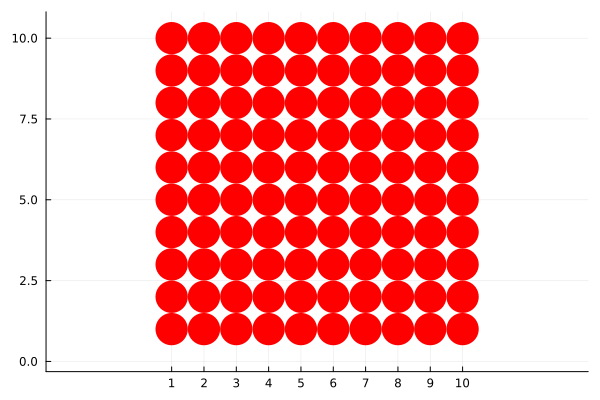

In [8]:
plot(núcleos, color = :red, lw = 0.0, xticks = 1:1:10,fill = true)

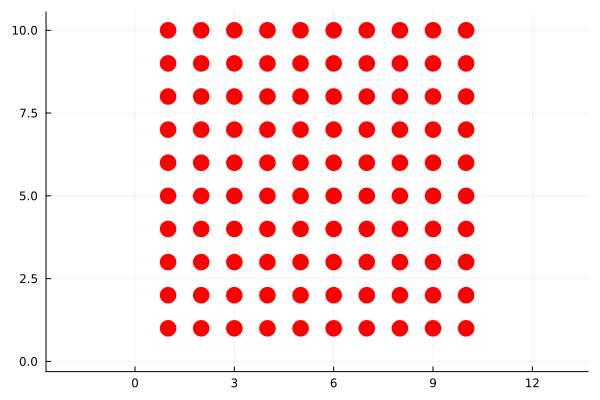

In [9]:
for p in núcleos
    p.radio = 0.25
end

plot(núcleos, color = :red, lw = 0.0, fill = true)

In [10]:
function mueve_obstáculo(particulas::Array{Particle}, δt)
    L = particulas[1].L
    i = rand(1:length(particulas))
    θ = 2π*rand()
    v = [cos(θ), sin(θ)]
    x_0, radio, nc = particulas[i].posicion, particulas[i].radio, particulas[i].celda
    x_1 = mod.(x_0 .+ v*δt, L)
    particula2 = Particle(x_1, 0.5, L) # Necesario definir r=0.5 primero para que la partícula esté en la celda correcta
    particula2.radio = radio
    return particula2, nc, radio, i, L
end

function revisa_intersección(particula2::Particle, i::Int, particulas::Array{Particle},
        celdas, vecinos)
    traslaciones = [L*[-1+i,-1+j] for i in 0:2 for j in 0:2]
    nc = particula2.celda
    celdas_a_revisar = [nc] ∪ vecinos[nc]
    for k in celdas_a_revisar
        indices = celdas[k]
        for j in indices
            if j ≠ i 
                for t in traslaciones
                    d = distancia(particula2 + t, particulas[j])
                    if d < particula2.radio+particulas[j].radio
                        return true
                    end
                end
            end
        end
    end
    return false
end

function metropolis_discos_duros(particulas, celdas, vecinos, δt)
    particula2, nc, radio, i, L = mueve_obstáculo(particulas, δt)
    nc2 = particula2.celda
    celdas2 = deepcopy(celdas)
    if nc ≠ nc2
        j = findfirst(x-> x == i, celdas2[nc])
        if j !== nothing
            deleteat!(celdas2[nc], j)
            push!(celdas2[nc2], i)
        end
    end 
    test = revisa_intersección(particula2, i, particulas, celdas2, vecinos)
    if test
        return particulas, celdas, i
    else
        particulas[i] = particula2
        return particulas, celdas2, i
    end
end

metropolis_discos_duros (generic function with 1 method)

In [11]:
function dibuja_celdas(L,radio)
    # Asumiendo un sistema cuadrado
    n = floor(L/(2*radio))
    l = L/n
    intersecciones = collect(0:l:L)
    hline!(intersecciones, lw=0.5,color=:red)
    vline!(intersecciones, lw=0.5,color=:red)
end

dibuja_celdas (generic function with 1 method)

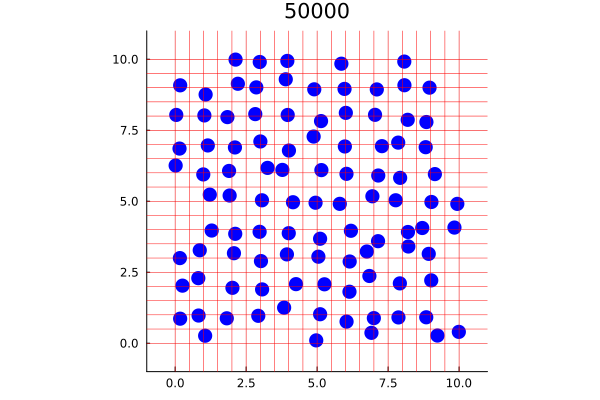

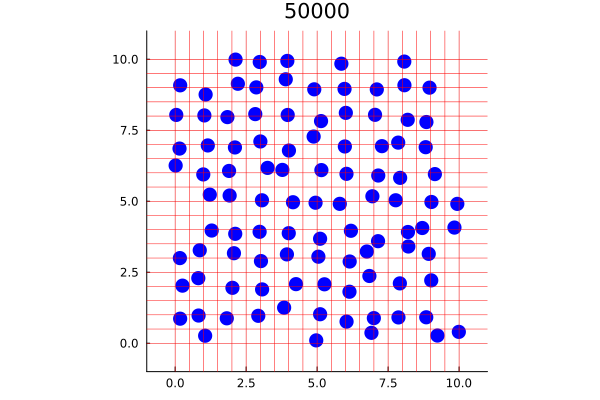

In [12]:
δt = 0.01
for i in 1:(50000)
    núcleos,celdas_p, j = metropolis_discos_duros(núcleos, celdas_p, vecinos, δt)
    if mod(i, 1000) == 0
        plot(aspect_ratio = 1)
        plot!(núcleos, fill = true, lw = 0, color = :blue, key = false)
        plot!(show = :ijulia, title = "$i", xlim = (-1,L+1), ylim = (-1,L+1))
    end   
end
dibuja_celdas(L,núcleos[1].radio)

Diremos que las partículas móviles son "electrones" y definiremos sus trayectorias usando lo que tenemos para los obstáculos, a los que llamamos "núcleos"

Primero, definimos cómo se moverán los electrones, para ello necesitamos una posición inicial, una velocidad inicial,
la posición de los obstáculos y mantener la pista de la celda de la partícula y qué obstáculos están en la celda. Por
fortuna esto está implementado en el objeto Particle.

Queremos implementar esto de forma que sea event drive, así que necesitamos calcular los timepos de los posibles eventos, estos son: La partícula llega a la frontera de una celda (4 tiempos posibles) o la partícula colisiona con un obstáculo (tiempo de colisión). Habrá que considerar el mínimo.

In [13]:
function calcula_celda(particula::Particle,n)
    L = particula.L
    radio = particula.radio
    posicion = particula.posicion
    
#     n = floor(L/(2*radio))
    l = L/n
    n_x, n_y = ceil(posicion[1]/l), ceil(posicion[2]/l)
    if n_y == 0
        n_y = 1
    end
    if n_x == 0
        n_x = 1
    end
    # OJO: habrá problemas con esta función si se sale del sistema LxL -> Pon condiciones de frontera periódicas o algo
#     println("nx: ",n_x," n_y: ",n_y)
    n_celda = Int(n_x + (n_y-1)*n)
end

calcula_celda (generic function with 1 method)

In [14]:
function tiempo_colision_frontera(electrón::Particle, n)
    # n es el número de celdas que hay -> n=floor(L/2*radio)
    # Tiempo que tarda en llegar a la frontera y a qué celda va a cambiar
    x = electrón.posicion
    v = electrón.velocidad
    cell = electrón.celda
    L = electrón.L
    radio = electrón.radio
    
    # Calcular los bordes de la celda
    l = L/n
    
    n_x = Int(mod1(cell,n))
    n_y = ceil(Int,cell/n)
    
    # Ojo con esto, esto implica que solo fucniona si la celda mide 1 de diámetro
    x1 = [n_x,n_y] .+ (l/2) .- 0.5
    x0 = [n_x,n_y] .- (l/2) .- 0.5
    
    # Celdas destino posibles
    cell_evol = Dict((1,1)=>[1,0],(1,2)=>[0,1],(2,1)=>[-1,0],(2,2)=>[0,-1])
    
    # Calcular los tiempos
    t1 = (x1 - x)./ v
    t0 = (x0 - x)./ v
    
    for i in 1:2
        time = t1[i]
        if 0 < time < Inf
            continue
        else
            t1[i] = Inf
        end
    end
    
    for i in 1:2
        time = t0[i]
        if 0 < time < Inf
            continue
        else
            t0[i] = Inf
        end
    end
    
    # Encontrar los mínimos y la celda
    ind_t1, mt1 = argmin(t1), min(t1[1],t1[2])
    ind_t0, mt0 = argmin(t0), min(t0[1],t0[2])
    
    
    t, ind_t = min(mt1,mt0), argmin([mt1,mt0])
    (ind_t==1) && (ind_t=(ind_t,ind_t1))
    (ind_t==2) && (ind_t=(ind_t,ind_t0))
    cell_bias = cell_evol[ind_t]
    
    return t
end


tiempo_colision_frontera (generic function with 1 method)

Ahora quiero aplicar la periodicidad del sistema

In [15]:
function frontera_periódica(pos,L)    
    new_pos = mod.(pos,L) 
    return new_pos
end

frontera_periódica (generic function with 1 method)

Creo que lo anterior funciona bien, ahora toca calcular el tiempo de colisión con un obstáculo y la velocidad de salida

In [16]:
@syms x0,y0,xc,yc,vx,vy,t,r

circle = sympy.Poly((x0 + vx*t - xc)^2 + (y0 + vy*t - yc)^2 - r^2,t)
circle.coeffs

PyObject <bound method Poly.coeffs of Poly((vx**2 + vy**2)*t**2 + (2*vx*x0 - 2*vx*xc + 2*vy*y0 - 2*vy*yc)*t - r**2 + x0**2 - 2*x0*xc + xc**2 + y0**2 - 2*y0*yc + yc**2, t, domain='ZZ[x0,y0,r,vx,vy,xc,yc]')>

In [17]:
function tiempo_colision_obstáculo(electrón::Particle, núcleo::Particle)
    xi = electrón.posicion
    vi = electrón.velocidad
    Xc = núcleo.posicion
    radio = núcleo.radio
    
    # Xc es el vector de posición del obstáculo (núcleo)
    x0, y0, vx, vy, xc, yc, r = xi[1], xi[2], vi[1], vi[2], Xc[1], Xc[2], radio
    a = vx^2 + vy^2
    b = 2*(vx*x0 - vx*xc + vy*y0 - vy*yc)/a
    c = (- r^2 + x0^2 - 2*x0*xc + xc^2 + y0^2 - 2*y0*yc + yc^2)/a
    
    Δ = b^2-4*c
#     println(Δ)
    if Δ<0
        t = Inf
    elseif (-b + sqrt(Δ)) < 0
        t = Inf
    else 
        t = -(b + sqrt(Δ))/2
    end
    return t
end

function choque_obstáculo(electrón, núcleo)
    #Función que tiene como argumentos el electron y el núcleo
    # y devuelve la velocidad final del electrón después del choque
    v0 = electrón.velocidad
    r = (electrón.posicion - núcleo.posicion)
    r ./= norm(r)
    v_orto = (r·v0)*r
    vf = v0 - 2 .*v_orto
    return vf
end

choque_obstáculo (generic function with 1 method)

Ahora el tiempo a un posible evento

In [18]:
function tiempo_a_evento(electrón::Particle, núcleos, n, celdas, vecinos)
    # Calcular los tiempos de los posibles eventos
    L = electrón.L
    cell = electrón.celda
    traslaciones = [[-1+i,-1+j] for i in 0:2 for j in 0:2].*L
    
    # Tiempo que tarda en cambiar de celda
    t_celda = tiempo_colision_frontera(electrón,n)  
    
    # Si el array de núcleos está vacío entonces solo puede chocar con la frontera
    if isempty(núcleos)
        return t_celda,0,0
    end 
    
    # Tiempo que tarda en colisionar con obstáculos en la celda actual y aledañas
    celdas_a_revisar = [cell] ∪ vecinos[cell]
    t_obs = Inf
    dist = Inf
    ind_nmc = 0
    
    for k in celdas_a_revisar
        indices = celdas[k]
        for j in indices
            for l in 1:length(traslaciones)
                núcleo = núcleos[j]
                núcleo.posicion = núcleo.posicion + traslaciones[l]
#                 if l ≠ 5
#                     núcleo.posicion = frontera_periódica(núcleo.posicion + traslaciones[l],L)
#                 else
#                     núcleo.posicion = núcleo.posicion + traslaciones[l]
#                 end
                t_new = tiempo_colision_obstáculo(electrón, núcleo)
                dist_new = distancia(electrón,núcleo)
                (t_new < t_obs) && (t_obs = t_new)
            
                if dist_new<dist
                    dist = dist_new
                    ind_nmc = j
                end
            end
        end
    end
    
    # Encontrar el mínimo
    t = min(t_obs,t_celda)
    
    # Regresar el tiempo, el núcleo más cercano y si choca con un obstáculo, regresa true
    if t_obs < t_celda
        return t, ind_nmc, true
    else
        return t, ind_nmc, false  
    end
end

tiempo_a_evento (generic function with 1 method)

Parece que funciona, lo ponemos en una función y tratamos de arreglar que choquen con los obstáculos en la frontera periódica

In [19]:
function  mueve_electrón(electrón::Particle, núcleos, n, celdas, vecinos; δt = 0.00001)
    L = electrón.L
    v = electrón.velocidad
    x = electrón.posicion
    
    # Encontrar tiempo a un evento
    t, ind_nmc, colisión = tiempo_a_evento(electrón, núcleos, n, celdas_p, vecinos) 
    
    # Evolucionar posición, velocidad y celda
    new_x = (x.+ t.*v)
    electrón.posicion = new_x
    
    (colisión) ? (new_v = choque_obstáculo(electrón,núcleos[ind_nmc])) : (new_v = v)
    
    electrón.velocidad = new_v
    electrón.posicion = frontera_periódica((electrón.posicion + δt*electrón.velocidad),L)
    electrón.celda = calcula_celda(electrón,n)
    return electrón, new_x, t, t+δt, v
end


mueve_electrón (generic function with 1 method)

In [20]:
plotly()
L = 2
radio = 0.5
n = floor(Int,L/(2*radio))
el_prueba = Particle([0.55,0.5], radio, L)
nu_prueba = Particle([L,L], radio, L)
núcleos = [nu_prueba]
traslaciones = [[-1+i,-1+j] for i in 0:2 for j in 0:2].*L


celdas_p = celdas(L)
vecinos = lista_de_vecinos(L);

for i in 1:length(núcleos)
    nc = núcleos[i].celda    
    push!(celdas_p[nc], i)
end
    
el_prueba.radio = 0.01
nu_prueba.radio = 0.2
for i in 1:length(núcleos)
    núcleos[i].radio = 0.2
end
el_prueba.velocidad = [1,1]*sqrt(2)
v = el_prueba.velocidad

pasos = 20
δt = 0.00001
X_tray = zeros(pasos)
Y_tray = zeros(pasos)
δX_tray = zeros(pasos)
δY_tray = zeros(pasos)
Tiempo = zeros(pasos)
δTiempo = zeros(pasos)
Vel_X = zeros(2*pasos)
Vel_Y = zeros(2*pasos)

X_tray[1] = el_prueba.posicion[1]
Y_tray[1] = el_prueba.posicion[2]
δX_tray[1] = el_prueba.posicion[1]
δY_tray[1] = el_prueba.posicion[2]
Vel_X[1:2] .= el_prueba.velocidad[1]
Vel_Y[1:2] .= el_prueba.velocidad[2]
δTiempo[1] = δt  

for i in 2:pasos
    el_prueba, x_evol, t, t_δt, old_v = mueve_electrón(el_prueba, núcleos, n, celdas, vecinos)
    X_tray[i] = x_evol[1]
    Y_tray[i] = x_evol[2]
    δX_tray[i] = el_prueba.posicion[1]
    δY_tray[i] = el_prueba.posicion[2]
    Vel_X[(i-1)*2+1] = old_v[1]
    Vel_Y[(i-1)*2+1] = old_v[2]
    Vel_X[(i-1)*2+2] = el_prueba.velocidad[1]
    Vel_Y[(i-1)*2+2] = el_prueba.velocidad[2]
    Tiempo[i] = t
    δTiempo[i] = t_δt
end

X_tray = collect(Iterators.flatten(zip(X_tray,δX_tray)))
Y_tray = collect(Iterators.flatten(zip(Y_tray,δY_tray)))
Velocidades = collect(zip(Vel_X,Vel_Y))
Tiempo = collect(Iterators.flatten(zip(Tiempo,δTiempo)))
Tiempo = Tiempo[2:end]

plot()
for k in 1:9
    if k ≠ 5
        plot!(nu_prueba+traslaciones[k],fill=true,color=:darkgreen,alpha=0.3,aspect_ratio=:equal,legend=false)
    else
        plot!(nu_prueba,fill=true,color=:green,alpha=0.8,aspect_ratio=:equal,legend=false)
    end
end
yticks!(0:L)
xticks!(0:L)
scatter!(X_tray,Y_tray,aspect_ratio=:equal,legend=false)
plot!(X_tray,Y_tray, color=:blue,aspect_ratio=:equal,legend=false)
dibuja_celdas(L,radio)
plot!([0,1,1,0,0].*L, [0,0,1,1,0].*L, color = :black, key = false, aspect_ratio = 1)
xlims!(-L/10,L*1.1)
ylims!(-L/10,L*1.1)

┌ Warning: For saving to png with the `Plotly` backend `PlotlyBase` and `PlotlyKaleido` need to be installed.
│   err =
│    ArgumentError: Package PlotlyBase not found in current path.
│    - Run `import Pkg; Pkg.add("PlotlyBase")` to install the PlotlyBase package.
└ @ Plots C:\Users\Esteban_AG\.julia\packages\Plots\tDHxD\src\backends.jl:586


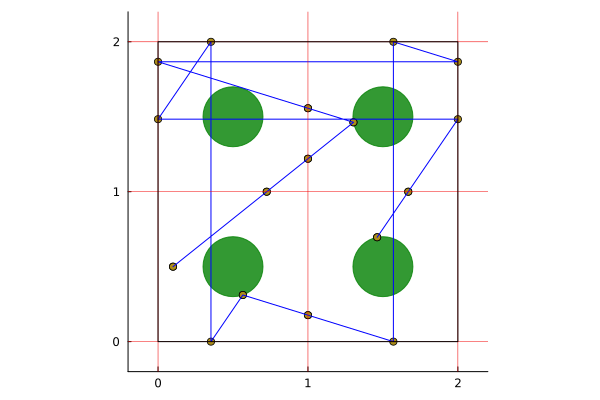

In [113]:
# gr()
L = 2
radio = 0.5
n = floor(Int,L/(2*radio))
el_prueba = Particle([0.1,0.5], radio, L)
nu_prueba = Particle([L,L], radio, L)
núcleos = condiciones_inicials_cuadradas(L, 0.5); 
traslaciones = [[-1+i,-1+j] for i in 0:2 for j in 0:2].*L


celdas_p = celdas(L)
vecinos = lista_de_vecinos(L);

for i in 1:length(núcleos)
    núcleos[i].posicion .-= [0.5,0.5]
    nc = núcleos[i].celda    
    push!(celdas_p[nc], i)
end

el_prueba.radio = 0.0
nu_prueba.radio = 0.2
for i in 1:length(núcleos)
    núcleos[i].radio = 0.2
end
el_prueba.velocidad = [1,0.8]/sqrt(2)
v = el_prueba.velocidad

pasos = 13
δt = 0.00001
X_tray = zeros(pasos)
Y_tray = zeros(pasos)
δX_tray = zeros(pasos)
δY_tray = zeros(pasos)
Tiempo = zeros(pasos)
δTiempo = zeros(pasos)
Vel_X = zeros(2*pasos)
Vel_Y = zeros(2*pasos)

X_tray[1] = el_prueba.posicion[1]
Y_tray[1] = el_prueba.posicion[2]
δX_tray[1] = el_prueba.posicion[1]
δY_tray[1] = el_prueba.posicion[2]
Vel_X[1:2] .= el_prueba.velocidad[1]
Vel_Y[1:2] .= el_prueba.velocidad[2]
δTiempo[1] = δt  

for i in 2:pasos
    el_prueba, x_evol, t, t_δt, old_v = mueve_electrón(el_prueba, núcleos, n, celdas, vecinos)
    X_tray[i] = x_evol[1]
    Y_tray[i] = x_evol[2]
    δX_tray[i] = el_prueba.posicion[1]
    δY_tray[i] = el_prueba.posicion[2]
    Vel_X[(i-1)*2+1] = old_v[1]
    Vel_Y[(i-1)*2+1] = old_v[2]
    Vel_X[(i-1)*2+2] = el_prueba.velocidad[1]
    Vel_Y[(i-1)*2+2] = el_prueba.velocidad[2]
    Tiempo[i] = t
    δTiempo[i] = t_δt
end

X_tray = collect(Iterators.flatten(zip(X_tray,δX_tray)))
Y_tray = collect(Iterators.flatten(zip(Y_tray,δY_tray)))
Velocidades = collect(zip(Vel_X,Vel_Y))
Tiempo = collect(Iterators.flatten(zip(Tiempo,δTiempo)))
Tiempo = Tiempo[2:end]
plot()
for nucleo in núcleos, k in 1:9
    if k ≠ 5
        plot!(nucleo+traslaciones[k],fill=true,color=:darkgreen,alpha=0.3,aspect_ratio=:equal,legend=false)
    else
        plot!(nucleo,fill=true,color=:green,alpha=0.8,aspect_ratio=:equal,legend=false)
    end
end
yticks!(0:L)
xticks!(0:L)
scatter!(X_tray,Y_tray,aspect_ratio=:equal,legend=false)
plot!(X_tray,Y_tray, color=:blue,aspect_ratio=:equal,legend=false)
dibuja_celdas(L,radio)
plot!([0,1,1,0,0].*L, [0,0,1,1,0].*L, color = :black, key = false, aspect_ratio = 1)
xlims!(-L/10,L*1.1)
ylims!(-L/10,L*1.1)

Función para dividir la trayectoria

In [114]:
function Dividir_Trayectoria(X_dado,Y_dado,T_dado,V_dado;δt=0.01)    
    # Parámetros de los puntos dados
    X = [[X_dado[i],Y_dado[i]] for i in 1:length(X_dado)] #collect(zip(X_dado,Y_dado))
    V = [[V_dado[i][1],V_dado[i][2]] for i in 1:length(V_dado)]
    Ts = cumsum(T_dado)
    N = ceil(Int,Ts[end]/δt)
    trayectoria = [zeros(2) for i in 1:N]
    tiempos = zeros(N)
    velocidades = [zeros(2) for i in 1:N]
    
    for i in 1:N
        Δt = i*δt
        j = findfirst(x->Δt<x,Ts)
        
        if j===nothing
            trayectoria[end] = X[end]
            tiempos[end] = Ts[end]
            velocidades[end] = V[end]
            break
        end
        
        Δt2 = 0
        if j>1
            Δt2 = Ts[j-1]
        end
        # Evolucionar posición y tiempo
        dt = Δt-Δt2
        x = X[j] + V[j]*dt
        trayectoria[i] = copy(x)
        tiempos[i] = Δt
        velocidades[i] = V[j]
        
    end
    return trayectoria, tiempos, velocidades
end

Dividir_Trayectoria (generic function with 1 method)

In [145]:
function Dividir_Trayectoria_V2(X,V,T;δt=0.01)    
    # Parámetros de los puntos dados
    Ts = cumsum(T)
    trayectoria = Any[]
    tiempos = Any[]
    velocidades = Any[]
    
    push!(trayectoria,X[1])
    push!(tiempos,T[1])
    push!(velocidades,X[1])
    seguro = 1
    
    for i in 1:length(X)-1
        j = 1
        while (j*δt)<T[i]
            if (j*δt)<T[i]
                x = X[i] + V[i]*(j*δt)
                push!(trayectoria,x)
                push!(tiempos,T[i]+(j*δt))
                push!(velocidades,V[i])
                j += 1
                (seguro>10000) && break
                seguro += 1
#                 @show (j*δt), T[i]
            else
                continue
            end                
        end
    end
    return trayectoria, tiempos, velocidades
end

Dividir_Trayectoria_V2 (generic function with 1 method)

In [150]:
X = [[X_tray[i],Y_tray[i]] for i in 1:length(X_tray)]
V = [[Velocidades[i][1],Velocidades[i][2]] for i in 1:length(Velocidades)]
tray, temps, vels = Dividir_Trayectoria_V2(X,V,Tiempo;δt=0.001)
length(temps)

10009

In [151]:
gr()
a = Animation()
plot()
for i in 1:50:length(tray)
    plt = scatter([tray[i][1]],[tray[i][2]]
                    ,xlims=(-1,5),ylims=(-1,5),legend=false)
    for nucleo in núcleos, k in 1:9
        if k ≠ 5
            plot!(nucleo+traslaciones[k],fill=true,color=:darkgreen,alpha=0.3,aspect_ratio=:equal,legend=false)
        else
            plot!(nucleo,fill=true,color=:green,alpha=0.8,aspect_ratio=:equal,legend=false)
        end
    end
    dibuja_celdas(L,radio)
    plot!([0,1,1,0,0].*L, [0,0,1,1,0].*L, color = :black, key = false, aspect_ratio = 1)
    title!("t=$i")
    xlims!(-L/10,L*1.1)
    ylims!(-L/10,L*1.1)
    frame(a,plt)
end

[ Info: Saved animation to C:\Users\Esteban_AG\Documents\UNAM\TSTFE\Tareas\Prueba_1.gif


Plots.AnimatedGif("C:\\Users\\Esteban_AG\\Documents\\UNAM\\TSTFE\\Tareas\\Prueba_1.gif")
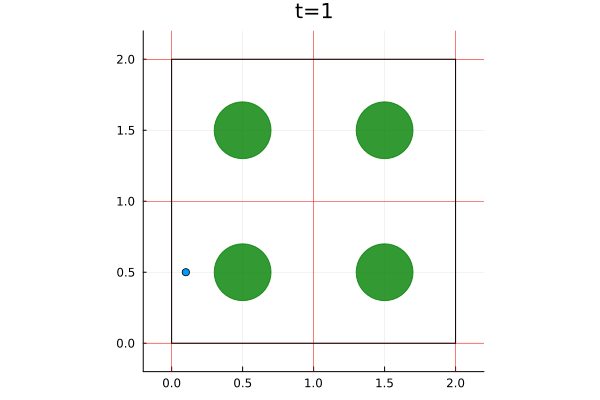

In [152]:
gif(a,"Prueba_1.gif",fps=10)

### Prueba con la función de Luis

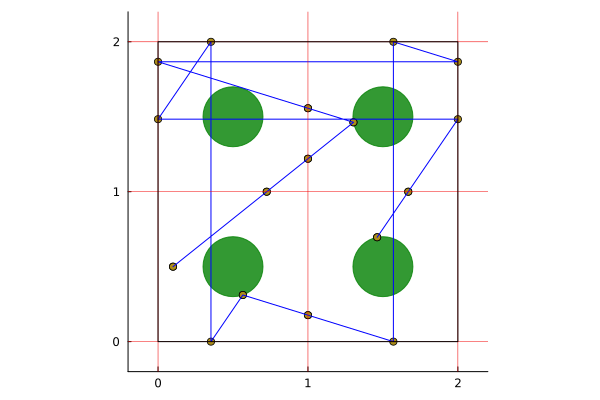

In [67]:
# gr()
L = 2
radio = 0.5
n = floor(Int,L/(2*radio))
el_prueba = Particle([0.1,0.5], radio, L)
nu_prueba = Particle([L,L], radio, L)
núcleos = condiciones_inicials_cuadradas(L, 0.5); 
traslaciones = [[-1+i,-1+j] for i in 0:2 for j in 0:2].*L


celdas_p = celdas(L)
vecinos = lista_de_vecinos(L);

for i in 1:length(núcleos)
    núcleos[i].posicion .-= [0.5,0.5]
    nc = núcleos[i].celda    
    push!(celdas_p[nc], i)
end

el_prueba.radio = 0.0
nu_prueba.radio = 0.2
for i in 1:length(núcleos)
    núcleos[i].radio = 0.2
end
el_prueba.velocidad = [1,0.8]/sqrt(2)
v = el_prueba.velocidad

pasos = 13
δt = 0.00001
X_tray = zeros(pasos)
Y_tray = zeros(pasos)
δX_tray = zeros(pasos)
δY_tray = zeros(pasos)
Tiempo = zeros(pasos)
δTiempo = zeros(pasos)
Vel_X = zeros(2*pasos)
Vel_Y = zeros(2*pasos)

X_tray[1] = el_prueba.posicion[1]
Y_tray[1] = el_prueba.posicion[2]
δX_tray[1] = el_prueba.posicion[1]
δY_tray[1] = el_prueba.posicion[2]
Vel_X[1:2] .= el_prueba.velocidad[1]
Vel_Y[1:2] .= el_prueba.velocidad[2]
δTiempo[1] = δt  

for i in 2:pasos
    el_prueba, x_evol, t, t_δt, old_v = mueve_electrón(el_prueba, núcleos, n, celdas, vecinos)
    X_tray[i] = x_evol[1]
    Y_tray[i] = x_evol[2]
    δX_tray[i] = el_prueba.posicion[1]
    δY_tray[i] = el_prueba.posicion[2]
    Vel_X[(i-1)*2+1] = old_v[1]
    Vel_Y[(i-1)*2+1] = old_v[2]
    Vel_X[(i-1)*2+2] = el_prueba.velocidad[1]
    Vel_Y[(i-1)*2+2] = el_prueba.velocidad[2]
    Tiempo[i] = t
    δTiempo[i] = t_δt
end

X_tray = collect(Iterators.flatten(zip(X_tray,δX_tray)))
Y_tray = collect(Iterators.flatten(zip(Y_tray,δY_tray)))
Velocidades = collect(zip(Vel_X,Vel_Y))
Tiempo = collect(Iterators.flatten(zip(Tiempo,δTiempo)))
# Tiempo = Tiempo[2:end]
plot()
for nucleo in núcleos, k in 1:9
    if k ≠ 5
        plot!(nucleo+traslaciones[k],fill=true,color=:darkgreen,alpha=0.3,aspect_ratio=:equal,legend=false)
    else
        plot!(nucleo,fill=true,color=:green,alpha=0.8,aspect_ratio=:equal,legend=false)
    end
end
yticks!(0:L)
xticks!(0:L)
scatter!(X_tray,Y_tray,aspect_ratio=:equal,legend=false)
plot!(X_tray,Y_tray, color=:blue,aspect_ratio=:equal,legend=false)
dibuja_celdas(L,radio)
plot!([0,1,1,0,0].*L, [0,0,1,1,0].*L, color = :black, key = false, aspect_ratio = 1)
xlims!(-L/10,L*1.1)
ylims!(-L/10,L*1.1)

In [105]:
function divide_trayectoria(posiciones, velocidades, ts; Δt=0.1)
    t = ts[end]
    pasos = ceil(Int, t/Δt)
    posiciones2 = fill(posiciones[1], pasos)
    velocidades2 = fill(velocidades[1], pasos)
    ts2 = collect(0:Δt:(pasos)*Δt)
    for i in 1:pasos-1
        
        t0 = Δt*i
        j = findfirst(x-> x > t0, ts)
        ts0 = 0.0
        if j > 1
            ts0 = ts[j-1]
        end
        dt = t0-ts0
        posiciones2[i+1] = posiciones[j] + velocidades[j] * dt
        velocidades2[i+1] = velocidades[j]
    end

    return posiciones2, velocidades2, ts2
end

divide_trayectoria (generic function with 1 method)

In [106]:
Tray_dada = [[X_tray[i],Y_tray[i]] for i in 1:length(X_tray)]
Vel_dada = [[Vel_X[i],Vel_Y[i]] for i in 1:length(Vel_X)]
ts = cumsum(Tiempo)
pos2, vel2, ts2 = divide_trayectoria(Tray_dada,Vel_dada,ts;Δt=0.01);

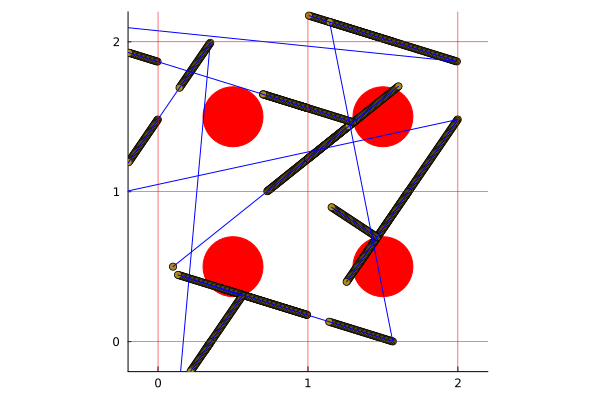

In [107]:
N = length(pos2)
cs = Any[]

for núcleo in núcleos
    push!(cs,núcleo.posicion)
end

plot(núcleos,0.2,color=:red,fill=true, aspect_ratio=1,key=false)
scatter!([(pos2[i][1], pos2[i][2]) for i in 1:N],aspect_ratio=:equal,legend=false)
plot!([(pos2[i][1],pos2[i][2]) for i in 1:N], color=:blue,aspect_ratio=:equal,legend=false)
 yticks!(0:L)
 xticks!(0:L)

dibuja_celdas(L,radio)
xlims!(-L/10,L*1.1)
ylims!(-L/10,L*1.1)

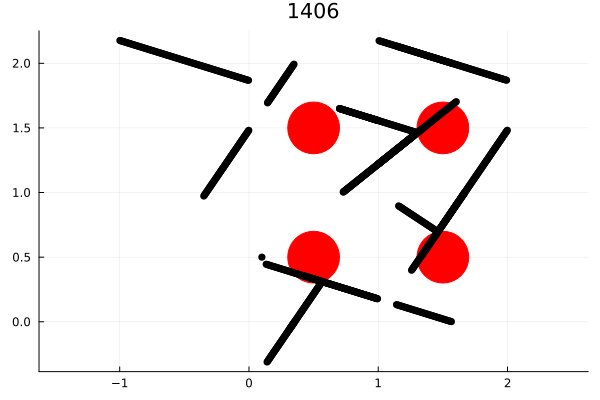

[ Info: Saved animation to C:\Users\Esteban_AG\Documents\UNAM\TSTFE\Tareas\tmp.gif


Plots.AnimatedGif("C:\\Users\\Esteban_AG\\Documents\\UNAM\\TSTFE\\Tareas\\tmp.gif")
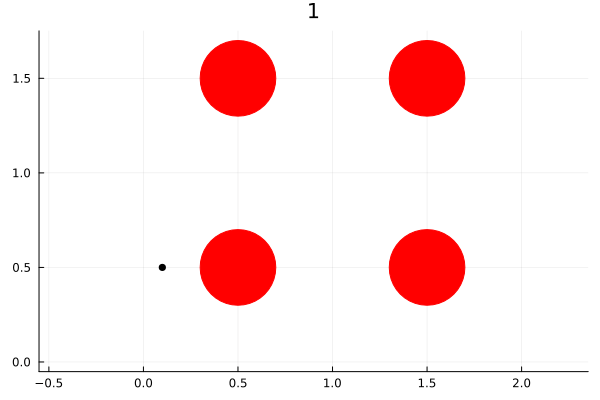

In [108]:
gr()
plot(núcleos,0.2,color=:red,fill=true, aspect_ratio=1,key=false)
@gif for i in 1:length(pos2)
   scatter!([pos2[i][1]],[pos2[i][2]],color = :black, markesize = 1, show = :ijulia,title ="$i")
# scatter!([posiciones2[i][1]+ncs2[i][1] for i in 1:length(posiciones2)],[posiciones2[i][2]+ncs2[i][2] for i in 1:length(posiciones2)])
end

[2] Haz una simulación de un gas de Lorentz desordenado. Es decir, ahora la posición de los obstáculos debe seguir una distribución Poissoniana (es decir, se debe ver como una distribución homogenea donde sea que se encuentre la partícula). Para esto tendrás que hacer un sistema finito. En este caso los obstáculos se pueden encimar. En este sistema mide también el desplazamiento cuadrático medio. ¿Hay alguna diferencia con el caso anterior? 

[3] Gas de fotones. Haz una simulación donde pongas partículas a revotar en una "placa", es decir, la frontera de tu sistema debe estar dada por una imagen que cargues (como con lo de resolver ecuaciones diferenciales parciales). Además tus partículas deben guardar qué celdas visitaron y en qué tiempo iban. Finalmente, para cada celda suma sus fases usando $sin(\omega_1 t)$ donde $t$ es el tiempo que llevaba recorriendo la partícula cuando entró en la celda. 

[4] Considera un gas de Lorentz periódico, pero ahora las partículas están cargadas eléctricamente y hay un gradiente de campo eléctrico en la dirección de $x$. Cuál es la corriente eléctrica promedio como función de $x$ (haz la simulación). 

[5] Ahora agrega un campo magnético ortogonal al plano de movimiento de las partículas, es decir, ahora las partículas se mueven formando círculos. ¿Cómo cambia la corriente eléctrica (el desplazamiento cuadrático medio) como función del campo magnético?